# Part 3: Integrate components and execute user text and image queries

## Step1: Upload the artifacts created in part 1 & 2

Upload below artifacts to your Colab workspace in the directory '/content'

1. Artifacts created in Part 1:
   - **stamp.csv**: The csv file tracking stamp data, including stamp_id, img_file_location, and image_description
   - **/img**: The folder storing all stamp images.

2. Artifacts created in Part 2:
   - **/txt**: The folder storing unstructured text files containing stamp value information

Retain below artifacts on your local PC/Mac for applicaiton testing later
1. Artifacts created in Part 1:
   - **/test**: The folder storing test images.

In [2]:
#define paths of artifacts for later use
from pathlib import Path
import pandas as pd
import os
csv_file_path = Path(r'./stamp.csv')
img_dir_path = Path(r'./img')
txt_dir_path = Path(r'./txt')

## Step2: Define utility functions
**Note:** These functions are identical to those used in Part 1.

In [3]:
#print_progress(): print a progress bar
#e.g. [██████████████████████████████--------------------] 60.67%
def print_progress(cur_data, total_data):
    total_bar = 50   #set total bar size to be 50
    cur_percent = (cur_data / total_data) * 100
    cur_bar = int((cur_data / total_data) * total_bar)
    cur_bar_display = '█' * cur_bar + '-' * (total_bar - cur_bar)
    print(f'\r[{cur_bar_display}] {cur_percent:.2f}%', end='\n' if cur_percent == 100 else '') #1)\r: return to linehead 2)end='': not print a new line

#display_stamps(): displays a list of stamps: [(stamp0 tuple), (stamp1 tuple), ...]
#stamp tuple format: (stamp_id, img_file_path, [opt1: similarity_distance], [opt2: scott_number, stamp_name, face_value, mint_value, used_value])
import matplotlib.pyplot as plt
import math
def display_stamps(stamp_list):
    stamp_count = len(stamp_list)
    display_col = 5          #set max 5 stamps per row
    display_row = math.ceil(stamp_count / display_col)
    fig, axes = plt.subplots(display_row, display_col)   #default fig size: 6.4in x 4.8in
    axes = axes.flatten()    #converts axes, whether a single row or multiple rows, into a one-dimensional NumPy array.
    for i, ax in enumerate(axes):
        if (i < stamp_count):
           stamp_id, file_path, *others = stamp_list[i]
           title = stamp_id                     #use stamp_id as the title for each stamp grid
           for item in range(len(others)):
              title += f'\n{others[item][:13]}' #append additional info to the title if available, max 13 characters per item
           cur_img_np = plt.imread(file_path)   #load the image of each grid from 'img_file_path'
           ax.set_title(title, loc='left')
           ax.imshow(cur_img_np)
           ax.axis('off')
        else:                                   #hide axes for empty grids (e.g., displaying 8 stamps in a 2x5 array leaves the last 2 grids empty).
           ax.set_visible(False)
    plt.rcParams['figure.constrained_layout.use'] = True #auto-adjust subplot spacing to prevent overlap
    plt.show()

#calculate the cost of API calls based on the number of tokens used
def calculate_token_cost(model, input_token_count=0, output_token_count=0):
    #default price per 1 million tokens
    input_token_price = 10.0
    output_token_price = 30.0
    #adjust prices based on model type
    if model == 'gpt-4-turbo-2024-04-09':
        pass  # Uses default prices
    elif model == 'text-embedding-ada-002-v2':
        input_token_price = 0.1
        output_token_price = 0.0
    cost = (input_token_count / 1_000_000 * input_token_price +
            output_token_count / 1_000_000 * output_token_price)
    return round(cost, 2)

## Step3: Convert stamp image descriptions to OpenAI embeddings and store them in ChromaDB

Here, we create a new ChromaDB from image descriptions, instead of copying the persisted ChromaDB from Part 1, because the embedding cost is negligible.  
**Note:** This step mirrors Step 5 in Part 1.

In [4]:
!pip -q install langchain openai tiktoken chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
#retrieve the OpenAI API key from Google Colab Secrets
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
api_key = os.environ['OPENAI_API_KEY']

In [6]:
#generate OpenAI embeddings for stamp image descriptions through langchain
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

img_df = pd.read_csv(csv_file_path)
#create embeddings for stamp image descriptions and store them in a vector database (ChromaDB)
#set img_df.iloc[:10].iterrows() to test the first 10 images
docs = [Document(page_content=row['image_description'], metadata={"stamp_id": row['stamp_id'], "file_location": row['file_location']}) for idx, row in img_df.iloc[:].iterrows()]
doc_ids = [str(i) for i in range(len(docs))]
#initialize ChromaDB to use as the vector database
vectordb = Chroma.from_documents(documents=docs,
                                 embedding=OpenAIEmbeddings(),                 #using OpenAI Embedding
                                 collection_metadata={"hnsw:space": "cosine"}, #set distance_function to cosine_similarity, https://docs.trychroma.com/usage-guide#changing-the-distance-function
                                 persist_directory='chroma_db',
                                 ids=doc_ids)
#persist the generated embeddings to ChromaDB
vectordb.persist()
#output the count of records stored in ChromaDB
print(f'records in chromadb: {vectordb._collection.count()}')


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


records in chromadb: 60


## Step4: Reuse functions from Part 1 to generate descriptions for user query images
**Note:** These functions are identical to those used in Part 1.  
In Part 1, these functions were used to generate descriptions for all stamp images in the demonstration pdf.  
In Part 3, the same functions are utilized to generate descriptions for stamp images from user queries.

In [7]:
#base64(): encode the image for OpenAI multi-modal model processing
import base64
def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

#requests(): call the OpenAI multi-modal API to get a textual description of the encoded image
import requests
import time
def gen_image_description(img_path, max_retry=5):
    base64_image = encode_image(img_path)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        #"model": "gpt-4-vision-preview",     #old multi-modal model
        "model": "gpt-4-turbo-2024-04-09",    #latest multi-modal model
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "describe this image in detail"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 1000
    }
    for attempt in range(1, max_retry + 1):
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        if response.status_code == 429: #handle throttling with exponential backoff
            wait = 2 ** attempt
            print(f"Retrying in {wait} seconds...", end='')
            time.sleep(wait)
        else:                           #for non-throttling status, go to next step
            break
    if response.status_code == 200:     #successful API response
        return response.json()
    else:                               #handle API failures
        print(f'\nAPI call failure: {response.status_code}')
        print(f'API call reponse: {response.json()}')
        return None

## Step5: Reuse functions from Part 2 to extract stamp value info from text files
**Note:**   These functions are identical to those used in Part 2.  


In [8]:
!pip -q install langchain langchain-openai

In [9]:
#extract_stamp_value_info(): extract stamp value information based on a user query, using the OpenAI API and the latest LLM model (gpt-4-turbo-2024-04-09)
from langchain_core.prompts.chat import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI

def extract_stamp_value_info(user_query, doc_content):

    openai_llm = ChatOpenAI(temperature=0, model_name='gpt-4-turbo-2024-04-09')

    system_template = SystemMessagePromptTemplate.from_template(
        "Assume the role of a helpful assistant with expertise in stamp collecting."
    )

    user_template = HumanMessagePromptTemplate.from_template(
        """
        {user_query}
        Please use the information in the provided document to determine the value.

        Document Content: {doc_content}

        The document contains information about stamp values in the format:
        "scott_number stamp_face_value stamp_name stamp_mint_value stamp_used_value"

        Note1: If the entry is for a stamp set, the 'scott_number' will contain a '-'.

        Note2: If specific value information is missing, '-' will be used to denote this.

        Structure your response as follows (no additional explaination required):
        "scott_number_or_stamp_set_number; stamp_name; face_value; mint_value; used_value"

        Note3: Use '-' in any fields where the information is not available.
        """
    )

    chat_prompt = ChatPromptTemplate.from_messages([system_template, user_template])

    chat_messages = chat_prompt.format_prompt(user_query=user_query, doc_content=doc_content).to_messages()
    # print(chat_messages)

    response = openai_llm(chat_messages)
    # print(response)

    return response

In [10]:
import re
#query_single_stamp_value(): extract stamp value information for a given Scott number using a LLM model API call
def query_single_stamp_value(scott_num, text_content):
    user_query = f'Determine the value of a stamp whose scott number is {scott_num}.'
    response = extract_stamp_value_info(user_query,  text_content)
    #print API call cost
    input_tokens = response.response_metadata['token_usage']['prompt_tokens']
    output_tokens = response.response_metadata['token_usage']['completion_tokens']
    cost = calculate_token_cost('gpt-4-turbo-2024-04-09', input_tokens, output_tokens)
    print(f'[LLM] token:{input_tokens}(input),{output_tokens}(output) cost:${cost}')
    #print query results
    print("[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]")
    print(response.content)
    scott_number, stamp_name, face_value, mint_value, used_value = re.split(r';', response.content)
    return (scott_number, stamp_name, face_value, mint_value, used_value, input_tokens, output_tokens, cost)

## Step6: Integrate all components into functions that support user image or text queries


**Scenario 1: User types in a stamp description**

The function integrated for this scenario is `query_stamp_value_by_stamp_description()`, organized into the following components:

1. **Search the database by text**
_-- Component: `search_vectordb_by_text()`_
 - When a user inputs a description of a stamp, we initiate a search in the vector database to identify the top k similar stamps (e.g., 5).

2. **Extract stamp value info**
_-- Component: `query_single_stamp_value()`_
 - For each stamp found, we retrieve the stamp's value information from a corresponding text file. Using the `stamp_id`, we determine the original pdf location (e.g. page 2), which corresponds to a specific text file (e.g. p2.txt) that contains the stamp value information. We then use OpenAI's LLM model to extract stamp value information from this unstructured document.

3. **Display results**
_-- Component: `display_stamps()`_
 - We display the stamps that most closely match the user's query, complete with stamps' value information.

**Scenario 2: User uploads a stamp image**

The function integrated for this scenario is `query_stamp_value_by_stamp_image()`, organized into the following components:

1. **Search the database by image**
_-- Component: `search_vectordb_by_image()`_

- **Image analysis**
_-- Component: `gen_image_description()`_
 - We first use OpenAI's multi-modal model to analyze the uploaded stamp image and generate a textual description of it.

- **Search the database by text**
_-- Component: `search_vectordb_by_text()`_
 - Utilizing the generated image description, we search the vector database for the top k similar stamps (e.g., 5), mirroring the text search process in Scenario 1 but starting with the image description.

2. **Extract stamp value info**
_-- Component: `query_single_stamp_value()`_
 - This process remains identical to Scenario 1, retrieving the stamps' value information from the corresponding text files using their `stamp_id`.

3. **Display results**
_-- Component: `display_stamps()`_
 - Similar to Scenario 1, we display the stamps that most closely match the description derived from the image, along with stamps' value information.


In [11]:
import re
#search_vectordb_by_text(): search the vector database with a text string and return the top k (default k=5) similar records
def search_vectordb_by_text(vectordb, query_text, max_result=5):
    docs = vectordb.similarity_search_with_score(query_text, k=max_result)
    #construct a stamp list: [(stamp0 tuple), (stamp1 tuple), ...]
    #stamp tuple format: (stamp_id, img_file_path, similarity_distance)
    stamp_list = [(doc[0].metadata['stamp_id'], doc[0].metadata['file_location'], f'{doc[1]:.3f}') for doc in docs]
    # stamp_image_description_list = [doc[0].page_content for doc in docs]
    return stamp_list

#search_vectordb_by_image(): convert an image to a text description and search the vector database for the top k similar records
def search_vectordb_by_image(vectordb, query_image_path, max_result=5):
    response = gen_image_description(query_image_path)
    #print API call cost
    input_tokens = response['usage']['prompt_tokens']
    output_tokens = response['usage']['completion_tokens']
    cost = calculate_token_cost('gpt-4-turbo-2024-04-09', input_tokens, output_tokens)
    print(f'[multi-modal] token:{input_tokens}(input),{output_tokens}(output) cost:${cost}')
    image_desciption = response['choices'][0]['message']['content']
    #print(image_desciption)
    stamp_list = search_vectordb_by_text(vectordb, image_desciption, max_result)
    return stamp_list

#update_stamp_list_with_value_info(): update the stamp list with additional value info extracted from associated unstructured text files
def update_stamp_list_with_value_info(stamp_list):
    total_input_tokens, total_output_tokens, total_cost = 0, 0, 0
    for i, stamp in enumerate(stamp_list):
        stamp_id, img_file_path, sim_dist = stamp_list[i]
        page_num, scott_num, seq_num = re.split(r'_', stamp_id)
        txt_file_path = os.path.join(txt_dir_path, f"{page_num}.txt")
        with open(txt_file_path, 'r') as file:
            file_content = file.read()
            scott_number, stamp_name, face_value, mint_value, used_value, input_tokens, output_tokens, cost = query_single_stamp_value(scott_num, file_content)
            #update each stamp tuple to include: (stamp_id, img_file_path, similarity_distance, scott_number, stamp_name, face_value, mint_value, used_value)
            stamp_list[i] =  (stamp_id, img_file_path, f"sim:{sim_dist}", f"scott:{scott_number}", f"name:{stamp_name}", f"face val:{face_value}", f"mint:{mint_value}", f"used:{used_value}")
            #accumulate token counts and track cost
            total_input_tokens += input_tokens
            total_output_tokens += output_tokens
            total_cost += cost
    #print the total API call cost
    print(f'[LLM] total_token:{total_input_tokens}(input),{total_output_tokens}(output) total_cost:${total_cost}')
    return stamp_list

#query_stamp_value_by_stamp_description(): query the vector database for stamp value info by provding a stamp description
def query_stamp_value_by_stamp_description(vectordb, text):
    print(f'[stamp description from user]{text}')
    stamp_list = search_vectordb_by_text(vectordb, text)
    # display_stamps(stamp_list)
    stamp_list_with_value_info = update_stamp_list_with_value_info(stamp_list)
    print(f'[query result]{stamp_list_with_value_info}')
    display_stamps(stamp_list_with_value_info)


#query_stamp_value_by_stamp_image(): query the vector database for stamp value info by provding a stamp image
def query_stamp_value_by_stamp_image(vectordb, img_path):
    print(f'[stamp image path from user]{img_path}')
    display_stamps([('stamp image user queried', img_path)])
    stamp_list = search_vectordb_by_image(vectordb, img_path)
    # display_stamps(stamp_list)
    stamp_list_with_value_info = update_stamp_list_with_value_info(stamp_list)
    print(f'[query result]{stamp_list_with_value_info}')
    display_stamps(stamp_list_with_value_info)

## Step7: Perform final testing of user queries

In [12]:
from google.colab import files
from PIL import Image
import io
import os
import shutil
#testing_user_text_query(): test Scenario 1 to ensure that stamps closely matching a user's text description are correctly returned along with their value information
def testing_user_text_query(vectordb):
    stamp_text_description = input("Please type in a stamp description:")
    query_stamp_value_by_stamp_description(vectordb, stamp_text_description)


#testing_user_img_query(): test Scenario 2 to verify that stamps aligning with a user's uploaded stamp image are returned, including their value information
def testing_user_img_query(vectordb):
    print("Please upload a stamp image:")
    uploaded = files.upload()
    #user uploaded images will be moved from working dir('/content') to '/content/tmp' folder
    tmp_dir_path = 'tmp'
    if not os.path.exists(tmp_dir_path):
        os.makedirs(tmp_dir_path)
    upload_img_file_name = next(iter(uploaded))
    tmp_img_file_name = os.path.join(tmp_dir_path, upload_img_file_name)
    shutil.move(upload_img_file_name, tmp_img_file_name)
    query_stamp_value_by_stamp_image(vectordb, tmp_img_file_name)

Please type in a stamp description:flag
[stamp description from user]flag


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


[LLM] token:1932(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4645; Freedom; 45¢; $3.25; $0.35
[LLM] token:1932(input),16(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4648; Justice; 45¢; 3.25; .35
[LLM] token:1932(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4646; Liberty; 45¢; $3.25; $0.35
[LLM] token:1932(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4642; Liberty; 45¢; $3.75; $0.50
[LLM] token:1932(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4641; Freedom; 45¢; $3.75; $0.50
[LLM] total_token:9660(input),88(output) total_cost:$0.1
[query result][('p0_4645_21', 'img/p0_4645_21.jpg', 'sim:0.191', 'scott:4645', 'name: Freedom', 'face val: 45¢', 'mint: $3.25', 'used: $

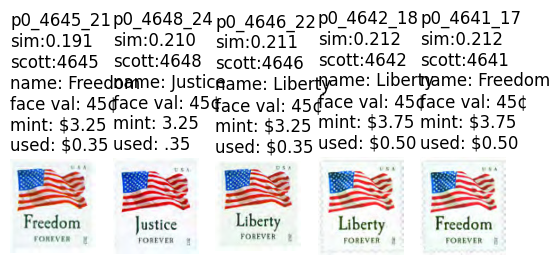

In [13]:
#[Exam]test Scenario 1: query using a stamp description to evaluate response accuracy.
#stamp desciption: "flag"
testing_user_text_query(vectordb)

Please type in a stamp description:tree
[stamp description from user]tree
[LLM] token:1932(input),22(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4620; Banyan – Cascade; 45¢; $5.00; $0.35
[LLM] token:1932(input),25(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4622; Azalea Plant – Multiple Trunk; 45¢; $5.00; $0.35
[LLM] token:1932(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4618; Sierra Juniper – Semi-cascade; 45¢; $5.00; $0.35
[LLM] token:1932(input),25(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4621; Trident Maple – Informal Upright; 45¢; $5.00; $0.35
[LLM] token:1932(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4619; Black Pine – Formal Upright; 45¢; $5.00; $0.35
[LLM] total_token:

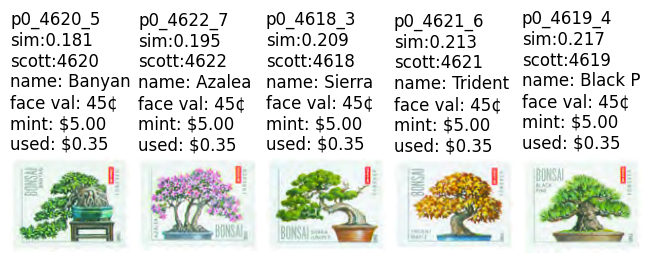

In [14]:
#stamp desciption: "tree"
testing_user_text_query(vectordb)

Please upload a stamp image:


Saving test1_1.png to test1_1.png
[stamp image path from user]tmp/test1_1.png


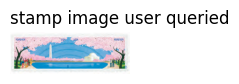

[multi-modal] token:267(input),212(output) cost:$0.01
[LLM] token:1934(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4651-52; Cherry Blossoms Centennial; 45¢; $6.50; $0.60
[LLM] token:1932(input),16(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4645; Freedom; 45¢; 3.25; .35
[LLM] token:1497(input),22(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4712-15; Christmas – Contemporary; 45¢; 13.95; 1.20
[LLM] token:1932(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4649; Priority Mail; $5.15; 22.95; 12.50
[LLM] token:1934(input),28(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4633-36; APU Coil, Perf. 9½; 45¢; $13.95; $1.25
[LLM] total_token:9229(input),110(output) total_cost:$0.1
[query result][('

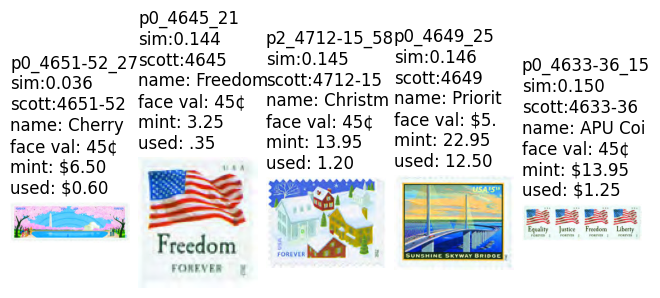

In [15]:
#[Exam]test Scenario 2: query with a training stamp image to assess recognition of familiar images
#stamp image from the '/test' folder on your local PC/Mac: test1_1.png
testing_user_img_query(vectordb)

Please upload a stamp image:


Saving test1_2.png to test1_2.png
[stamp image path from user]tmp/test1_2.png


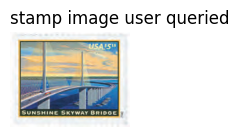

[multi-modal] token:267(input),152(output) cost:$0.01
[LLM] token:1932(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4649; Priority Mail; $5.15; 22.95; 12.50
[LLM] token:1497(input),28(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4717-20; Waves; $1, $2, $5, $10; $72.50; $49.95
[LLM] token:1932(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4650; Express Mail; $18.95; 64.95; 44.95
[LLM] token:1934(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4651-52; Cherry Blossoms Centennial; 45¢; $6.50; $0.60
[LLM] token:1495(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4711; Christmas – Traditional; 45¢; 3.25; .35
[LLM] total_token:8790(input),110(output) total_cost:$0.1
[query resul

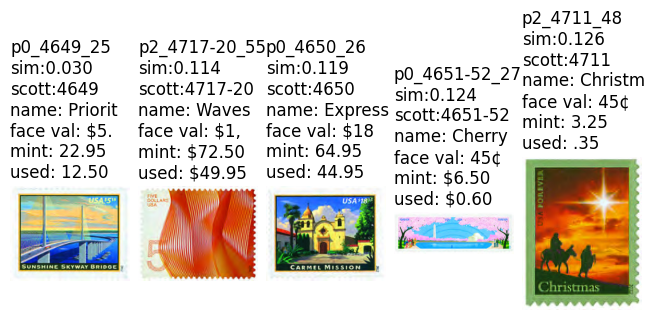

In [16]:
#stamp image from the '/test' folder on your local PC/Mac: test1_2.png
testing_user_img_query(vectordb)

Please upload a stamp image:


Saving test1_3.png to test1_3.png
[stamp image path from user]tmp/test1_3.png


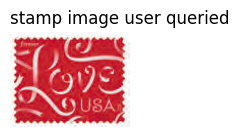

[multi-modal] token:267(input),104(output) cost:$0.01
[LLM] token:1932(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4626; Love Ribbons; 45¢; $3.50; $0.35
[LLM] token:1495(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4726; Lunar New Year; 45¢; 3.25; .50
[LLM] token:1932(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4641; Freedom; 45¢; $3.75; $0.50
[LLM] token:1497(input),26(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4706-09; Four Flags, ATM Bklt; 45¢; $16.95; $10.50
[LLM] token:1497(input),28(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4717-20; Waves; $1, $2, $5, $10; $72.50; $49.95
[LLM] total_token:8353(input),110(output) total_cost:$0.1
[query result][('p0_4626_9', 'img/p0

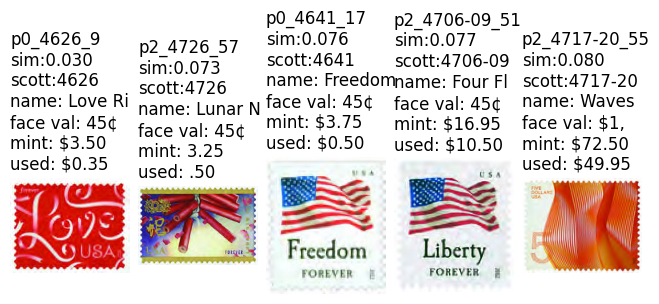

In [17]:
#stamp image from the '/test' folder on your local PC/Mac: test1_3.png
testing_user_img_query(vectordb)

Please upload a stamp image:


Saving test2_1.png to test2_1.png
[stamp image path from user]tmp/test2_1.png


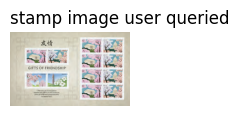

[multi-modal] token:267(input),200(output) cost:$0.01
[LLM] token:1934(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4651-52; Cherry Blossoms Centennial; 45¢; $6.50; $0.60
[LLM] token:1932(input),25(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4621; Trident Maple – Informal Upright; 45¢; $5.00; $0.35
[LLM] token:1495(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4726; Lunar New Year; 45¢; 3.25; .50
[LLM] token:1932(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4619; Black Pine – Formal Upright; 45¢; $5.00; $0.35
[LLM] token:1497(input),22(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4712-15; Christmas – Contemporary; 45¢; 13.95; 1.20
[LLM] total_token:8790(input),113(output) tota

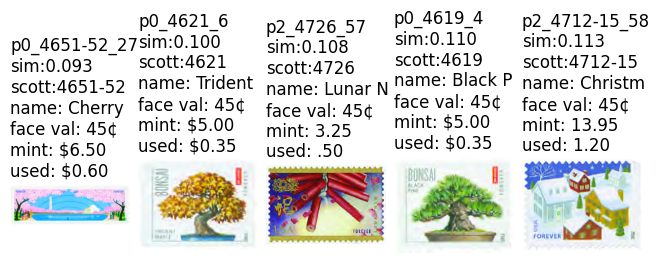

In [18]:
#[Exam]Test Scenario 2: query with an unseen stamp image to test the application's adaptability to new images
#stamp image from the '/test' folder on your local PC/Mac: test2_1.png
testing_user_img_query(vectordb)

Please upload a stamp image:


Saving test2_2.png to test2_2.png
[stamp image path from user]tmp/test2_2.png


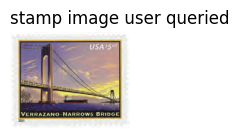

[multi-modal] token:267(input),171(output) cost:$0.01
[LLM] token:1932(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4649; Priority Mail; $5.15; 22.95; 12.50
[LLM] token:1497(input),28(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4717-20; Waves; $1, $2, $5, $10; $72.50; $49.95
[LLM] token:1854(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4666; Distinguished American; 45¢; $3.25; $1.75
[LLM] token:1495(input),25(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4703; War of 1812: USS Constitution; 45¢; 3.25; 1.25
[LLM] token:1934(input),24(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4651-52; Cherry Blossoms Centennial; 45¢; $6.50; $0.60
[LLM] total_token:8712(input),117(output) total_cost:$0.

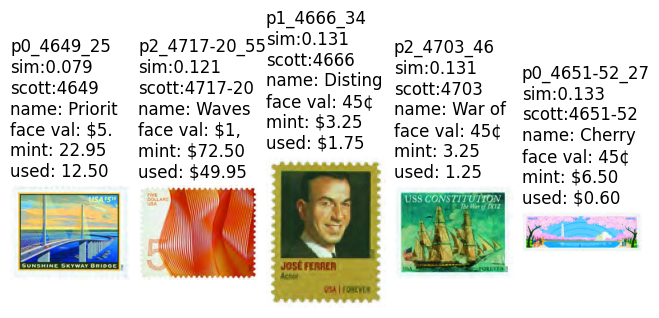

In [19]:
#stamp image from the '/test' folder on your local PC/Mac: test2_2.png
testing_user_img_query(vectordb)

Please upload a stamp image:


Saving test2_3.png to test2_3.png
[stamp image path from user]tmp/test2_3.png


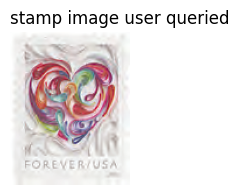

[multi-modal] token:267(input),191(output) cost:$0.01
[LLM] token:1932(input),20(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4626; Love Ribbons; 45¢; $3.50; $0.35
[LLM] token:1495(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4726; Lunar New Year; 45¢; 3.25; .50
[LLM] token:1932(input),18(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4641; Freedom; 45¢; $3.75; $0.50
[LLM] token:1497(input),22(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4712-15; Christmas – Contemporary; 45¢; 13.95; 1.20
[LLM] token:1934(input),28(output) cost:$0.02
[scott_number_or_stamp_set_number, stamp_name, face_value, mint_value, used_value]
4633-36; APU Coil, Perf. 9½; 45¢; $13.95; $1.25
[LLM] total_token:8790(input),106(output) total_cost:$0.1
[query result][('p0_4626_9', 'img/p

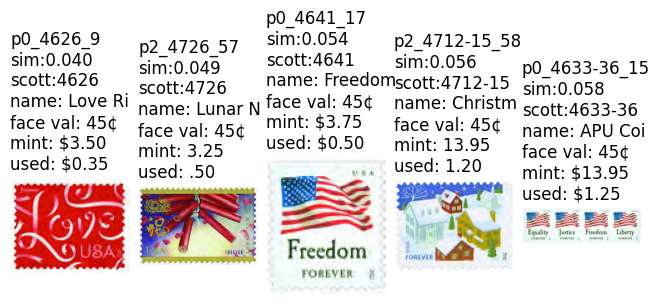

In [20]:
#stamp image from the '/test' folder on your local PC/Mac: test2_3.png
testing_user_img_query(vectordb)